# <center> Personality Profile Prediction </center>

![](https://collegepublicspeakingresources.files.wordpress.com/2014/09/myersbriggs1.jpg)

# Table of contents

# <center> Classify a person's MBTI personality type using text from what they post online. </center><a id="index"></a>

[](http://)1. [Introduction](#1)
2. [Importing Packages & Data](#2)
3. [Text Preprocessing](#3)
4. [Text to Features ](#4)
5. [Text Classification](#5)
    * [Model Validation](#)
    * [Other Models Used](#)
    * [Final model](#)
    
6. [Submission](#6)
7. [Conclusion](#7)


<a id="1"></a>

# 1. Introduction

In this challenge, you will be required to build and train a model (or many models) capable of predicting a person's MBTI label using only what they post in online forums.

This challenge will require the use of Natural Language Processing to convert the data into machine learning format. This data will then be used to train a classifier capable of assigning MBTI labels to a person's online forum posts.

Each person will have only one of the two categories for each variable above. Combining the four variables gives the final personality type. For example, a person who is **Extraverted**, **Intuitive**, **Thinking** and **Judging** will get the ENTJ personality type.

You will need to build and train a model that is capable of predicting labels for each of the four MBTI variables - i.e. predict four separate labels for each person which, when combined, results in that person's personality type.

<a id="2"></a>

# 2. Importing Packages & Data

Importing all the necessary packages and input data thats going to be necessary for our predictions.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv', 'random_example.csv']


In [2]:
# import train and test set
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
test.head()

,id,posts
0,1,Musical Linguistic Logic & Naturalist (tied)|...
1,2,'You: hello :) Stranger: hii You: how are you ...
2,3,'What worked for me was knowing that limerence...
3,4,'Please forget about him. You should definitel...
4,5,"'Ooh, ENTJ Celestia is actually an interesting..."


<a id="3"></a>

# 3. Text Preprocessing

Since, our text is in an unstructured form, various types of noise are present in it and the data is not readily analyzable without any pre-processing. In this section we go through the entire process of cleaning and standardization of text, making it noise-free and ready for analysis.

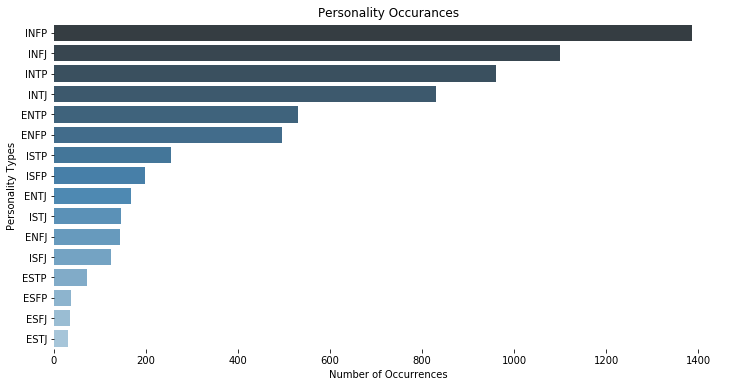

In [5]:
# visualise the occurances/distribution of all the class types.
num_c = train['type'].value_counts()
f, ax = plt.subplots(figsize=(12,6))
sns.barplot( num_c.values, num_c.index, palette="Blues_d")
ax.xaxis.grid(False)
ax.set(xlabel="Number of Occurrences")
ax.set(ylabel="Personality Types")
ax.set(title="Personality Occurances")
sns.despine(trim=True, left=True, bottom=True)

In [6]:
# drop the  'Id' colum since it's unnecessary for the prediction process.
train_type = train[['type']]
test_ID = test['id']
train.drop(['type'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [7]:
# put all the features together to enable quick transformation process
post_features = pd.concat([train, test],sort=False).reset_index(drop=True)
post_features.head()

,posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,'I'm finding the lack of me in these posts ver...
2,'Good one _____ https://www.youtube.com/wat...
3,"'Dear INTP, I enjoyed our conversation the o..."
4,'You're fired.|||That's another silly misconce...


In [8]:
# using regular expressions for dealing with special patterns of noise.
pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
post_features = post_features.replace(to_replace = pattern, value = ' ', regex = True)

In [9]:
post_features.head()

,posts
0,' ||| |||enfp and intj moments sportscente...
1,'I'm finding the lack of me in these posts ver...
2,"'Good one _____ |||Of course, to which I s..."
3,"'Dear INTP, I enjoyed our conversation the o..."
4,'You're fired.|||That's another silly misconce...


Here we are going to go through the three steps of **Noise Removal**(Any piece of text which is not relevant to the context of the data and the end-output can be specified as the noise), **Lexicon Normalization**(Another type of textual noise is about the multiple representations exhibited by single word), **Object Standardization**(Text data often contains words or phrases which are not present in any standard lexical dictionaries. These pieces are not recognized by models). These will enable us to get our data into a format that we can work with.

In [10]:
# creating a cleaned corpus
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

lem = WordNetLemmatizer() # returns the actual root word of a text token
# ps = PorterStemmer() # cuts off the surfix but doesnt necessarily return the root word
corpus =[]
# cleaning text
for i in range(0,len(post_features['posts'])):

    post = re.sub('[^a-zA-Z]', ' ',str(post_features.iloc[i].values)) 
    post = post.lower()
    post = post.split()
    # ps.stem(word) #MethodAttempt
    stop_wrds = set(stopwords.words('english'))
    post = [lem.lemmatize(word, "v") for word in post if not word in stop_wrds]
    post = ' '.join(post)
    corpus.append(post)

post_features['posts_clean'] = corpus
post_features.drop(['posts'], axis=1, inplace=True)              

In [11]:
post_features.head()

,posts_clean
0,enfp intj moments sportscenter top ten play pr...
1,find lack post alarm sex bore position often e...
2,good one course say know bless curse absolutel...
3,dear intp enjoy conversation day esoteric gabb...
4,fire another silly misconception approach logi...


<a id="4"></a>

# 4. Text to Features (Feature Engineering on text data)

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques. Here we are going to use **Statistical features**. Here text data is quantified directly into numbers using several techniques implemented in this section. **Term Frequency – Inverse Document Frequency (TF – IDF**) and **CountVectorizer**.

In [12]:
# Create Ranked Statistical Features with TfidfVectorizer, best choice because insignificant words recieve a lower rank
obj = TfidfVectorizer()
post_final_features = obj.fit_transform(post_features['posts_clean'])
print(post_final_features[0])

#AnotherMethodAttempt
# Create Ranked Statistical Features with CountVectorizer has no ranking machanism
# obj = CountVectorizer() 
# post_final_features = obj.fit_transform(post_features['posts_clean']).toarray()
# print(post_final_features[0:5])

  (0, 51321)	0.022971753095914153
  (0, 71096)	0.01986360970350271
  (0, 4062)	0.047274026208539495
  (0, 18316)	0.09498645008638615
  (0, 82020)	0.01596645415910647
  (0, 14567)	0.053867316511501555
  (0, 47093)	0.06500552884892956
  (0, 54808)	0.07320038515485536
  (0, 25468)	0.06060195869391936
  (0, 7586)	0.027894891259623238
  (0, 58435)	0.04538429404512145
  (0, 7408)	0.021206654335971402
  (0, 69879)	0.029399599740099487
  (0, 1498)	0.027917308013944236
  (0, 84642)	0.02183200436723868
  (0, 70189)	0.028175502555248942
  (0, 60135)	0.043232650308424714
  (0, 25455)	0.041018094693615934
  (0, 1400)	0.032429904556302395
  (0, 49908)	0.02854634446563593
  (0, 65751)	0.024802541253978988
  (0, 53456)	0.027598014612381074
  (0, 1600)	0.06274183478703248
  (0, 84762)	0.04596298373355101
  (0, 71609)	0.06592524469693782
  :	:
  (0, 51400)	0.03262506371186185
  (0, 72390)	0.059059136897429226
  (0, 14036)	0.052354713799169145
  (0, 25335)	0.04572854782274967
  (0, 58495)	0.0187643849744

In [13]:
# label extraction and creating our target variables from personality types
pd.options.mode.chained_assignment = None
yc = pd.DataFrame(train_type['type'])
train_type['I-E'] = train_type['type'].astype(str).str[0]
train_type['I-E'] = train_type['I-E'].map({"I": 0, "E": 1})
train_type['S-N'] = train_type['type'].astype(str).str[1]
train_type['S-N'] = train_type['S-N'].map({"S": 0, "N": 1})
train_type['F-T'] = train_type['type'].astype(str).str[2]
train_type['F-T'] = train_type['F-T'].map({"F": 0, "T": 1})
train_type['P-J'] = train_type['type'].astype(str).str[3]
train_type['P-J'] = train_type['P-J'].map({"P": 0, "J": 1})
train_type.drop('type', axis=1, inplace=True) 
y = train_type
print(y[0:5])

   I-E  S-N  F-T  P-J
0    0    1    0    1
1    1    1    1    0
2    0    1    1    0
3    0    1    1    1
4    1    1    1    1


In [14]:
y = np.array(y)
print(y[0:5])

[[0 1 0 1]
 [1 1 1 0]
 [0 1 1 0]
 [0 1 1 1]
 [1 1 1 1]]


Separating the data into a proper training(X,y) and the testing(X_final_test) set.

In [15]:
# Spliting the data back to train(X,y) and test(X_sub)
X = post_final_features[:len(y), :]
X_final_test = post_final_features[len(y):, :]
print('Features size for train(X,y) and test(X_final_test):')
print('X', X.shape, 'y', y.shape, 'X_final_test', X_final_test.shape)

Features size for train(X,y) and test(X_final_test):
X (6506, 85722) y (6506, 4) X_final_test (2169, 85722)


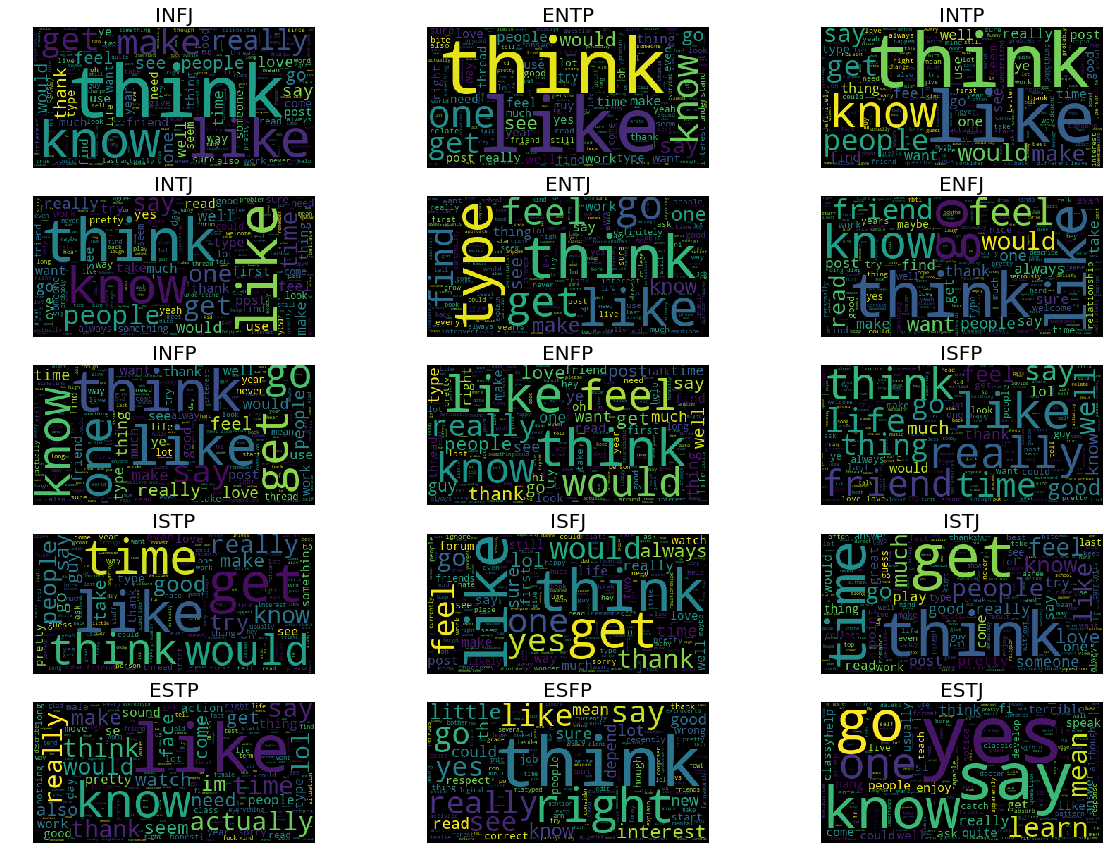

In [16]:
# wordcloud of the most frequently used words by each personality
yc['posts_clean'] = post_features['posts_clean']
labels = yc['type'].unique()
row, col = 5, 3
wc = WordCloud(stopwords = ['infj','entp','intp','intj', 'isfps','istps','isfjs','istjs',
                             'entjs','enfjs','infps','enfps','entj','enfj','infp','enfp',
                             'estps','esfps','estjs','esfjs','isfp','istp','isfj','istj',
                             'estp','esfp','estj','esfj','infjs','entps','intps','intjs'])
fig, ax = plt.subplots(5, 3, figsize=(20,15))
for i in range(5):
    for j in range(3):
        c_type = labels[i*col+j]
        c_ax = ax[i][j]
        df = yc[yc['type'] == c_type]
        wordc = wc.generate(df['posts_clean'].to_string())
        c_ax.imshow(wordc)
        c_ax.axis('off')
        c_ax.set_title(label=c_type,fontdict = {'fontsize': 20})

<a id="5"></a>

# 5. Text Classification

Text classification, in common words is defined as a technique to systematically classify a text object (document or sentence) in one of the fixed category. In these case we have 8 categories(**(I-E)**, **(S-N)**, **(F-T)**, **(P-J)**) that we are classifiying. 

* **Model Bulding and Validation**

In [17]:
# Predicting model
model = OneVsRestClassifier(LogisticRegressionCV(Cs=30, solver = 'saga',
                                                       multi_class = 'multinomial', cv=5), n_jobs =-1)

In [18]:
# split the train set to create a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [19]:
# train model with 80% of train set
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=30, class_weight=None,
                                                   cv=5, dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1.0,
                                                   l1_ratios=None, max_iter=100,
                                                   multi_class='multinomial',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   refit=True, scoring=None,
                                                   solver='saga', tol=0.0001,
                                                   verbose=0),
                    n_jobs=-1)

In [20]:
# predict 20% of train set
y_pred = model.predict(X_test)

In [21]:
# performance matrics and model eveluation using sklearn.metrics inbuilt classification metric
print(classification_report(y_test, y_pred, target_names=['Mind', 'Energy', 'Nature', 'Tactics']))

              precision    recall  f1-score   support

        Mind       0.74      0.53      0.62       309
      Energy       0.91      0.98      0.95      1130
      Nature       0.86      0.83      0.84       612
     Tactics       0.81      0.65      0.72       507

   micro avg       0.87      0.83      0.85      2558
   macro avg       0.83      0.75      0.78      2558
weighted avg       0.86      0.83      0.84      2558
 samples avg       0.86      0.82      0.82      2558



*  **Other Models Used**

These models did not work very well compared to the LogisticRegressionCV. These was based on accuracy score and execution time. LogisticRegressionCV had a much better accuracy and with its build in cross validation method, helped to avoid overfitting.

In [22]:

#AnotherMethodAttempt
# from sklearn.naive_bayes import MultinomialNB
# model = OneVsRestClassifier(MultinomialNB())

In [23]:
#AnotherMethodAttempt
# from sklearn.neighbors import KNeighborsClassifier
# model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))

* **Final Model**

The hyperparameters where selected manually through trial and error. Other hyperparameter tuning models like GridSearchCV did not work due to multi-class classification nature of our model.

In [24]:
# Reinitialise final model
model = OneVsRestClassifier(LogisticRegressionCV(Cs=30, solver = 'saga',
                                                 multi_class = 'multinomial', cv=10), n_jobs =-1)

In [25]:
# train final model with full train set 
model.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=30, class_weight=None,
                                                   cv=10, dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1.0,
                                                   l1_ratios=None, max_iter=100,
                                                   multi_class='multinomial',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   refit=True, scoring=None,
                                                   solver='saga', tol=0.0001,
                                                   verbose=0),
                    n_jobs=-1)

In [26]:
# pridicting the actual test set (X_final_test)
y_predicted = model.predict(X_final_test)

In [27]:
# Final model results
y_predicted[0:5]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1]])

Visualising Accuracy and Distribution of each class/category of our test data. This is the best alternative to visualise the model accuracy as we cannot do it with the usual accuracy matrics methods as they require the target variable y which we do not have for the test dataset.

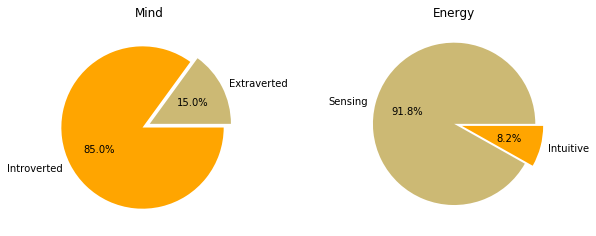

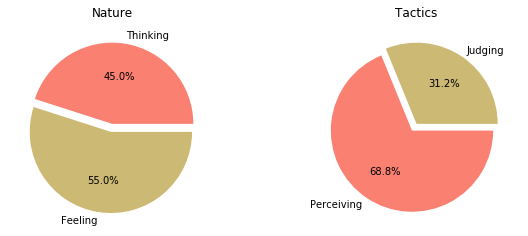

In [28]:
# Plot the accuracy for each classifier
f, ax = plt.subplots(figsize=(20, 10))
sns.set_color_codes(palette='deep')
plt.subplots_adjust(wspace = 0.5)
ax = plt.subplot(2, 4, 1)
plt.pie([sum(y_predicted[:,0]), len(y_predicted[:,0]) - sum(y_predicted[:,0])],
        labels = ['Extraverted', 'Introverted'],explode = (0, 0.1),autopct='%1.1f%%', colors=['y','orange'])
ax.set(title="Mind")

ax = plt.subplot(2, 4, 2)
plt.pie([sum(y_predicted[:,1]), len(y_predicted[:,1]) - sum(y_predicted[:,1])], 
        labels = ['Sensing', 'Intuitive'],explode = (0, 0.1),autopct='%1.1f%%', colors=['y','orange'])
ax.set(title="Energy")

f, ax2 = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.5)

ax2 = plt.subplot(2, 4, 1)
plt.pie([sum(y_predicted[:,2]), len(y_predicted[:,2]) - sum(y_predicted[:,2])], 
        labels = ['Thinking', 'Feeling'],explode = (0, 0.1),autopct='%1.1f%%', colors=['salmon','y'])
ax2.set(title="Nature")

ax2 = plt.subplot(2, 4, 2)
plt.pie([sum(y_predicted[:,3]),  len(y_predicted[:,3]) - sum(y_predicted[:,3])], 
        labels = ['Judging', 'Perceiving'], explode = (0, 0.1), autopct='%1.1f%%', colors=['y','salmon'])
ax2.set(title="Tactics")
plt.show()


<a id="6"></a>

# 6. Submission

Submission of the predicted results from our test data. The predicted array is sliced into 4 categories(**mind** (I-E), **energy** (S-N), **nature** (F-T), **tactics** (P-J) to match the required prediction format.

In [29]:
# format submission of the predicted classes
submission = pd.DataFrame({'id' : np.array(test_ID),'mind' : y_predicted[:,0], 
                           'energy' : y_predicted[:,1], 'nature' : y_predicted[:,2], 
                           'tactics' : y_predicted[:,3]})
print('Save submission')

Save submission


In [30]:
# save DataFrame to csv file for submission
# submission.to_csv("new_submission.csv", index=False)

# 7. Conclusion

<a id="7"></a>

From our analysis we can conclude that the most common personality type based on our test set is **ISFP** (Introverted Sensing Feeling Perceiving). These is based on comments that are obtained from the test set that does not necessarily represent the whole population of users because we have a limited dataset and its only those who participate in comments.